In [1]:
from ProbaData import *

from supreshelper import *

from SimpleCNN import SimpleCNN

import tensorflow as tf
import time

from IPython.display import clear_output

In [2]:
data_dir = "DataGenerated/"
ds = ProbaVDataset("DataGenerated/")

In [3]:
def _parse_function(example_proto):
    keys_to_features = {'all':tf.io.FixedLenFeature((384, 384*3), tf.float32)}
    parsed_features = tf.io.parse_single_example(example_proto, keys_to_features)
    return ds.load_train_image(parsed_features['all'])

### Define our datasets from TFrecords

In [4]:
BUFFER_SIZE = 1500
batch_size = 2

train_dataset = tf.data.TFRecordDataset(glob(data_dir +  "train/*/*/all.tfrecords"))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
#train_dataset = train_dataset.repeat()  
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE) 
train_dataset = train_dataset.batch(batch_size)

In [5]:
dev_dataset = tf.data.TFRecordDataset(glob(data_dir +  "dev/*/*/all.tfrecords"))
train_dataset = train_dataset.shuffle(30)
#dev_dataset = dev_dataset.repeat()  
dev_dataset = dev_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE) 
dev_dataset = dev_dataset.batch(batch_size)

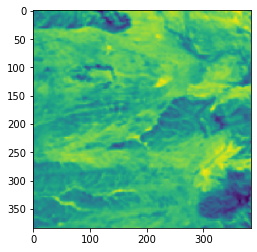

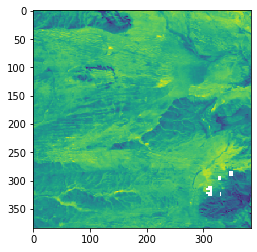

In [6]:
for a in train_dataset.take(1):
    plt.figure()
    plt.imshow(a[0][0][:,:,0])
    plt.figure()
    plt.imshow(a[1][0][:,:,0])

In [7]:
model = SimpleCNN()

In [8]:
def clearMSE(generated, hr):
    """As defined in https://kelvins.esa.int/proba-v-super-resolution/scoring/
    
        MSE loss that takes into account brightness and stuff TODO
    """
    quality_map = tf.where(hr == np.NaN, 0.0, 1.0)
    generated_ = tf.math.multiply(generated, quality_map)
    hr_ = tf.math.multiply(hr, quality_map)
    
    # calculate bias brightness
    bias = tf.math.reduce_mean(generated_ - hr_) # TODO divide by number #bias
    loss = tf.math.reduce_mean(tf.pow(hr_ - (generated_ - bias), 2)) # TODO divide by number #bias

    return loss

In [9]:
a = tf.random.uniform([384,384,1], dtype=tf.float32)
b = tf.random.uniform([384,384,1], dtype=tf.float32)

clearMSE(a,b)

<tf.Tensor: id=1148, shape=(), dtype=float32, numpy=0.1660027>

In [10]:
from tensorflow.keras.optimizers import Adam
LAMBDA = 100

In [11]:
EPOCHS = 5000
optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [12]:
checkpoint_dir = './TrainingCheckpointSimple'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 model=model.simpleCNN)

In [13]:
def model_loss(generated, hr):
    loss = clearMSE(generated, hr)
    return loss

In [14]:
@tf.function
def compute_loss(lr, hr):
    gen_output = model.simpleCNN(lr, training=True)
    cMse = model_loss(gen_output, hr)
    return cMse

In [15]:
@tf.function
def train_step(lr, hr):
    with tf.GradientTape() as model_tape:
        loss = compute_loss(lr, hr)
        # We compute gradient for each part
        model_gardients = model_tape.gradient(loss, model.simpleCNN.trainable_variables)
        # We apply the gradient to the variables, tf2.0 way
        optimizer.apply_gradients(zip(model_gardients, model.simpleCNN.trainable_variables))

In [16]:
train_step(tf.random.uniform([1,384,384,1], dtype=tf.float32), tf.random.uniform([1,384,384,1], dtype=tf.float32))

W0710 15:35:07.078785 140630208132928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
def show_dev_pred(generator, lr, hr):
    predicted = generator.predict(lr)
    plt.figure(figsize=(15,15))
    
    display_list = [lr[0][:,:,0], predicted[0][:,:,0], hr[0][:,:,0]]
    title = ['Input Image', 'Predicted Image', 'Real image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()
    

In [18]:
losses_record = []

def train(train_dataset, dev_dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        if (epoch + 1) % 50 == 0:
            for lr, hr in dev_dataset.take(1):
                print("Showing current result")
                show_dev_pred(model.simpleCNN, lr, hr)
            
        loss = 0
        for lr, hr in dev_dataset:
            loss += compute_loss(lr, hr)

        losses_record.append(loss)
        
        for lr, hr in train_dataset:
            train_step(lr, hr)
        
        # saving (checkpoint) the model every 100 epochs
        if (epoch + 1) % 100 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        if (epoch + 1) % 1 == 0:
            print('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))
            print('current losses: (gen / disc) ' + str(gen_loss.numpy()) + "/" + str(disc_loss.numpy()))
            print('=============================================')

In [19]:
train(train_dataset, dev_dataset, EPOCHS)

Time taken for epoch 1 is 112.64261722564697 sec



NameError: name 'gen_loss' is not defined

In [64]:
start = time.time()

for lr, hr in dev_dataset.take(1):
    pass

print("time to train one step: " + str(time.time()-start))

time to train one step: 0.04542088508605957


In [39]:
for lr, hr in train_dataset:
    start = time.time()
    train_step(lr, hr)
    print("time to train one step: " + str(time.time()-start))

time to train one step: 0.006078958511352539
time to train one step: 0.20643091201782227
time to train one step: 0.18483352661132812
time to train one step: 0.18664813041687012
time to train one step: 0.18414735794067383
time to train one step: 0.18308424949645996
time to train one step: 0.17113614082336426
time to train one step: 0.18534111976623535
time to train one step: 0.18680620193481445
time to train one step: 0.1862473487854004
time to train one step: 0.18799495697021484
time to train one step: 0.18693017959594727
time to train one step: 0.1807107925415039
time to train one step: 0.19646930694580078
time to train one step: 0.18570971488952637
time to train one step: 0.19188904762268066
time to train one step: 0.1809062957763672
time to train one step: 0.1799485683441162
time to train one step: 0.18967723846435547
time to train one step: 0.18570780754089355
time to train one step: 0.18859362602233887
time to train one step: 0.1851789951324463
time to train one step: 0.1946141719

KeyboardInterrupt: 